In [1]:
import torch
import utils
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Make sure to set this after `%matplotlib inline`
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')

In this notebook, we'll start by deriving and implementing the solution to linear regression by gradient descent. We'll extend this solution to the case of logistic regression and try to implement AND and XOR logic gates via logistic regression. We'll extend our logistic regression solution to implement a neural network and solve XOR. Finally, we'll explore a few properties of a neural network that's learned a semantic network (Rumelhart and Todd 1993).

# Linear Regression

While linear regression might seem a strange place to start, it's a simple and intuitive problem that will help us work up to a neural network. We hope to find a linear mapping between inputs $\{x_i\}^m_{i=1}$ and associated outputs $\{y_i\}^m_{i=1}$. So, we're looking for a $w$ and $b$ that makes good predictions $\hat{y}_i = w x_i+b$. We'll evaluate this based on the mean of the squared error between our predictions $\{\hat{y}_i\}^m_{i=1}$ and the true values $\{y_i\}^m_{i=1}$, which we'll call the loss, or $J(w, b)$. Here are the equations we'll be working with:

\begin{align}
\hat{y}_i &= w x_i+b \\
J(w, b) &= \frac{1}{m} \sum_{i=1}^m (\hat{y}_i-y_i)^2 \\
\end{align}

There are many ways to find the best $w$ and $b$ for this function: You can imagine randomly testing different values, trying all "reasonable" values, or taking a step in many possible directions to see which minimize $J(w, b)$. We can use the derivative of $J(w, b)$ to determine the best direction to change a point to minimize $J(w, b)$.  While the gradient won't always lead you to the best solution, the $J(w, b)$ that we're trying to minimize has very nice theoretical properties that actually guarantee that we'll find the optimal solution! (Though note that this isn't the case for the neural networks we'll explore later).

We'll start by working out the derivative of $\hat{y}_i$ w.r.t. $w$ which will be useful when we compute the derivative of loss.

\begin{align}
\frac{d}{dw}\hat{y}_i &= \frac{d}{dw}(wx_i+b) = x_i \\
\frac{d}{db}\hat{y}_i &= \frac{d}{db}(wx_i+b) = 1 \\
\end{align}

To find weights that minimize the loss, we'll find the gradient of the loss $J$ w.r.t. the weight $w$

\begin{align}
\frac{d}{dw} J(w, b) &= \frac{d}{dw} \left( \frac{1}{m} \sum_{i=1}^m (\hat{y}_i-y_i)^2 \right) \\
&= \frac{1}{m} \sum_{i=1}^m \frac{d}{dw} (\hat{y}_i-y_i)^2\\
&= \frac{1}{m} \sum_{i=1}^m 2 (\hat{y}_i-y_i) \frac{d}{dw} (\hat{y}_i-y_i) \\
&= \frac{1}{m} \sum_{i=1}^m 2 (\hat{y}_i-y_i) x_i \\
\end{align}

Following a similar set of steps, you can also figure out that $\frac{d}{db} J(w, b) = \frac{1}{m} \sum_{i=1}^m 2 (\hat{y}_i-y_i)$.

_For the curious_: You might wonder why we minimize the mean squared error! Kind of seems like a hack... Curiously, it is equivalent to a maximum likelihood estimate, assuming the $y_i$ come from a linear model with Gaussian noise added. See [Ryan Adam's COS 324 notes](https://www.cs.princeton.edu/courses/archive/fall18/cos324/files/mle-regression.pdf) or [the Deep Learning textbook](https://www.deeplearningbook.org/contents/ml.html) for derivations.

I referred to [this blog post](https://mccormickml.com/2014/03/04/gradient-descent-derivation/) in working through these derivations.

## Finding a fit...

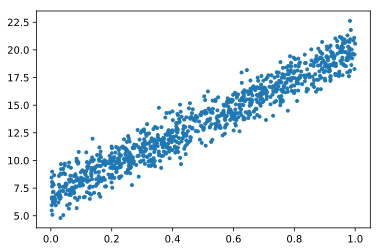

In [2]:
w, b = 13, 7

torch.manual_seed(42)
X = torch.rand(size=(1000,))
Y = w * X + b + torch.randn(size=X.shape)
plt.plot(X, Y, '.');

We'll try to find the parameters of the best linear model. We'll assume we know the intercept $b=7$ and try to solve for $w$ by using $\frac{dJ}{dw}$. We'll minimize our loss $J$ by changing $w$ a small amount based on the gradient $\frac{dJ}{dw}$. We'll then repeat the process on our latest estimate of $w$. We'll let $w_t$ denote the weight $w$ at step $t$ of this process. So our algorithm looks like

$$
w_{t+1} = w_t - \alpha * \frac{dJ}{dw_t}
$$

We'll compute the derivatives, perform gradient descent, and plot the steps it takes to find weight $w=13$.

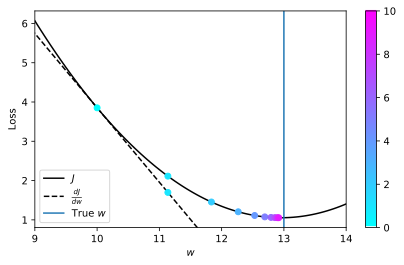

In [3]:
cmap = plt.get_cmap('cool')
learning_rate = .6
ws = torch.linspace(9, 14, 101)
epochs = 10
w = 10

f, ax = plt.subplots(figsize=(7, 4))

def activate(w, b):
    Yhat = w * X + b
    J = ((Y-Yhat)**2).mean()
    dJ_dw = (2 * (Yhat - Y) * X).mean()
    dJ_db = (2 * (Yhat - Y)).mean()
    return Yhat, J, dJ_dw, dJ_db

# Show the loss function for our ws
plt.plot(ws, [activate(w, 7)[1] for w in ws], 'k', label='$J$')

# Plot the gradient at w_0
t = 0
Yhat, J, dJ_dw, dJ_db = activate(w, 7)
lim = 10
xlim, ylim = plt.xlim(), plt.ylim()
plt.plot([w-lim, w+lim], [J-lim*dJ_dw, J+lim*dJ_dw], '--', c='k', label='$\\frac{dJ}{dw}$')
plt.xlim(xlim)
plt.ylim(ylim)
h = learning_rate * dJ_dw
plt.plot(w-h, J-h*dJ_dw, 'o', c=cmap((t+1)/epochs))

# Gradient descent!
for t in range(epochs):
    Yhat, J, dJ_dw, dJ_db = activate(w, 7)
    plt.plot(w, J, 'o', c=cmap(t/epochs))
    w -= learning_rate * dJ_dw

plt.axvline(13, label='True $w$')

sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=0, vmax=epochs), cmap=cmap)
sm.set_array(range(epochs))
f.colorbar(sm, ax=ax)
ax.set(ylabel='Loss', xlabel='$w$', xlim=[ws.min(), ws.max()])
plt.legend();

Now, we'll choose an arbitrary starting point and optimize both $w$ and $b$.

Estimate of w tensor([12.8859]) Estimate of b tensor([7.0280])


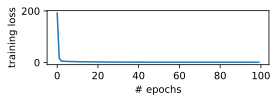

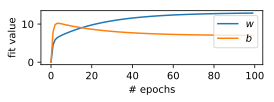

In [4]:
torch.manual_seed(42)
w = torch.randn(size=(1,)) * 1e-3
b = torch.randn(size=(1,)) * 1e-3

learning_rate = 0.3
history = []

for t in range(100):
    Yhat, J, dJ_dw, dJ_db = activate(w, b)
    history.append((w.item(), b.item(), J))
    w -= learning_rate * dJ_dw
    b -= learning_rate * dJ_db

print('Estimate of w', w, 'Estimate of b', b)

f, ax = plt.subplots(figsize=(4, 1))
plt.plot([h[2] for h in history])
plt.xlabel('# epochs')
plt.ylabel('training loss')

f, ax = plt.subplots(figsize=(4, 1))
plt.plot([h[0] for h in history], label='$w$')
plt.plot([h[1] for h in history], label='$b$')
plt.xlabel('# epochs')
plt.ylabel('fit value')
plt.legend()
None

# Logistic Function

Linear regression is really great, but if we hope to predict categorical labels (like `true` vs `false`, or `cat` vs `dog`), we might want a function that gives values between 0 and 1. We'll use the logistic or sigmoid function to accomplish this.

Below are a few logistic functions. You can change the steepness of the function (the gain, or $k$ below) as well as where it has the value 0.5 (the bias, or $x_0$ below). If we interpret the value from a sigmoid as a probability and round it to get a prediction, then the bias relates to the decision boundary!

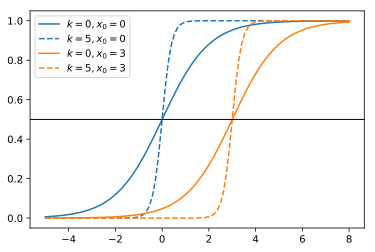

In [5]:
xs = torch.linspace(-5, 8, 100)
l, = plt.plot(xs, xs.sigmoid(), label='$k=0,x_0=0$')
plt.plot(xs, (5*xs).sigmoid(), label='$k=5,x_0=0$', c=l.get_color(), ls='--')
l, = plt.plot(xs, (xs - 3).sigmoid(), label='$k=0,x_0=3$')
plt.plot(xs, (5*(xs - 3)).sigmoid(), label='$k=5,x_0=3$', c=l.get_color(), ls='--')
plt.axhline(0.5, lw=1, c='k')
plt.legend();

Here's the equation for the sigmoid function $\sigma(z)$:

$$\sigma(z) = \frac{1}{1+e^{-z}}$$

And since we'll be using gradient descent, we'll note the derivative here too:

$$\frac{d}{dz} \sigma(z) = (1 - \sigma(z)) \sigma(z) $$

In numpy, you'll have to implement it:

```python
def logistic(z):
    return 1 / (1 + np.exp(-z))
```

But in PyTorch, we get the logistic function for free: `z.sigmoid()`!

To compute the above lines, we used $\sigma(k(x-x_0))$. If you let $w=k$ and $b=-kx_0$, then we can formulate this as a linear function followed by a logistic function $\sigma(wx+b)$.

_For the curious_: I've left out the derivation of the derivative of the sigmoid. For a derivation, refer to [Ryan Adam's COS324 Notes](https://www.cs.princeton.edu/courses/archive/fall18/cos324/files/logistic-regression.pdf).

_For the curious_: The logistic function is a special case of the softmax function over vectors of length 2.

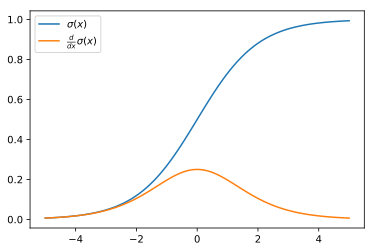

In [6]:
def logistic_derivative(z):
    return z.sigmoid() * (1 - z.sigmoid())

xs = torch.linspace(-5, 5, 100)
plt.plot(xs, xs.sigmoid(), label='$\sigma(x)$')
plt.plot(xs, logistic_derivative(xs), label='$\\frac{d}{dx} \sigma(x)$')
plt.legend();

## Logistic Regression

We can use the logistic function to compute things that live between 0 and 1, like probabilities or one-hot vectors (Is this a cat or not?). Combining this with linear regression means we can learn the gain and bias!

\begin{align}
z_i &= w x_i+b \\
\hat{y}_i &= \sigma(z_i) \\
\end{align}

The chain rule makes it really easy to work the derivative out. If you have functions $f$ and $g$ and want to compute the derivative of their composition $g(f(a))$ with respect to an input $a$, you can simplify the expression into two derivatives: $\frac{dg(f(a)}{df(a)}$ and $\frac{df(a)}{da}$.

\begin{align}
b = f(a) \\
c = g(b) = g(f(a)) \\
\frac{dc}{da} = \frac{dc}{db} \frac{db}{da} = \frac{dg(b)}{db} \frac{df(a)}{da} \\
\end{align}

To work out the derivative of the logistic regression model, we'll first apply the chain rule, then work out the two simpler derivatives. The derivative of the sigmoid is given above, and the derivative of the linear function is the same as our linear regression derivation.

\begin{align}
\frac{d}{dw}\hat{y}_i &= \frac{d}{dw}\sigma(z_i) \\
&= \frac{d}{dz_i}\sigma(z_i) \frac{d}{dw}(w x_i+b) \\
&= (1 - \sigma(z_i)) \sigma(z_i) x_i \\
\end{align}

Since we have the same objective $J(w, b) = \frac{1}{m} \sum_{i=1}^m (\hat{y}_i-y_i)^2$, we can skip to the part of our above derivation where we plugged in $\frac{d\hat{y}}{dw}$.

\begin{align}
\frac{d}{dw} J(w, b) &= \frac{1}{m} \sum_{i=1}^m 2 (\hat{y}_i-y_i) \frac{d}{dw} (\hat{y}_i-y_i) \\
&= \frac{1}{m} \sum_{i=1}^m 2 (\hat{y}_i-y_i) (1 - \sigma(z)) \sigma(z) x_i \\
\end{align}

You can follow the above steps to also compute $\frac{dJ}{db}= \frac{1}{m} \sum_{i=1}^m 2 (\hat{y}_i-y_i) (1 - \sigma(z)) \sigma(z)$.


We'll now code this up in PyTorch, but compare these derivatives to the ones PyTorch can compute automatically. The key elements in the code below are 1) marking a parameter you seek to optimize with `requires_grad=True` and 2) running the `.backward()` function on your loss!

_For the curious_: COS324 has [nice lecture notes](https://www.cs.princeton.edu/courses/archive/fall18/cos324/files/backprop.pdf) detailing the implementation of automatic differentiation. A simple method involves computing gradients at all steps; PyTorch does something more complicated, with `requires_grad=True` introducing bookkeeping and `.backward()` only computing the necessary gradients.

In [7]:
w = torch.randn((), requires_grad=True)
b = torch.randn((), requires_grad=True)

z = w * X + b
Yhat = z.sigmoid()
J = ((Y-Yhat)**2).mean()
dJ_dw = (2 * (Yhat - Y) * logistic_derivative(z) * X).mean()
dJ_db = (2 * (Yhat - Y) * logistic_derivative(z)).mean()

# Very powerful!
J.backward()

print('dJ/dw', dJ_dw.detach(), 'Automatic', w.grad)
print('dJ/db', dJ_db.detach(), 'Automatic', b.grad)

dJ/dw tensor(-3.4929) Automatic tensor(-3.4929)
dJ/db tensor(-6.1402) Automatic tensor(-6.1402)


## Learning logic

Now we'll try to learn logical functions! We'll focus on two: AND and XOR

|x|y|x &#124; y|x & y|x ^ y|
|---|---|---|---|---|
|0|0|0|0|0|
|0|1|1|0|1|
|1|0|1|0|1|
|1|1|1|1|0|

We've written a few functions below to compute predictions, the loss $J$, and show the accuracy of our model. We also have a utility function `utils.fit()` that we use to perform gradient descent using PyTorch. Here's a simplified version of `utils.fit()`:

```python
def fit(loss, parameters, lr):
    history = []
    opt = torch.optim.SGD(parameters, lr=lr)

    for t in range(num_epochs):
        # Compute the loss and save to history
        J = loss()
        history.append(J)

        # Zero our gradients. Very important for PyTorch's bookkeeping to be accurate.
        opt.zero_grad()

        # Now we propogate gradients backward from our loss $J$
        J.backward()

        # Finally we take a step in the direction of the gradient for each of our parameters
        opt.step()

    # We plot the training loss history
    plt.plot(history)
    plt.xlabel('# epochs')
    plt.ylabel('training loss')
```

Accuracy 100.0%


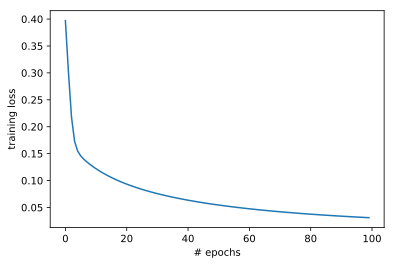

In [8]:
X = torch.tensor([[0, 0], [0, 1], [1, 0], [1, 1]]).float().T
Y = torch.tensor([0, 0, 0, 1]).float()

torch.manual_seed(42)
W = torch.rand((1, 2), requires_grad=True)
b = torch.rand((1,), requires_grad=True)

def predict(X):
    return (W@X + b[:, None]).sigmoid()

def loss():
    return ((Y-predict(X))**2).mean()

def show_accuracy(Yhat, Y):
    acc = (Y==Yhat.round()).float().mean()
    print(f'Accuracy {acc*100:.01f}%')

times, history, parameter_history = utils.fit(loss, [W, b], lr=2., num_epochs=100)
show_accuracy(predict(X), Y)

We can render the decision boundary below. The dimensions below correspond to the 2 dimensions of the input and the four points correspond to the four possible inputs values `00`, `01`, `10`, and `11`.

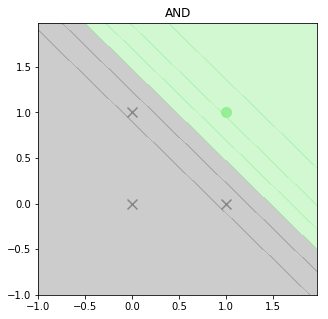

In [9]:
utils.plot_decision_regions(predict, X, Y, title='AND');

In [10]:
make_predict = lambda W, b: lambda X: (W@X + b[:, None]).sigmoid()
utils.animate_decision_regions(X, Y, [make_predict(W, b) for W, b in parameter_history[::3]], filename='resources/logistic-and.mp4')

Now we'll try to learn XOR with the same model. Our loss never hits zero and the decision boundary clearly shows the model will have issues with this dataset.

Accuracy 25.0%


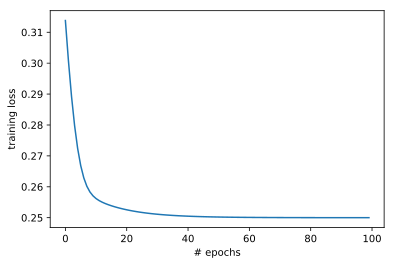

In [11]:
X = torch.tensor([[0, 0], [0, 1], [1, 0], [1, 1]]).float().T
Y = torch.tensor([0, 1, 1, 0]).float()

torch.manual_seed(42)
W = torch.rand((1, 2), requires_grad=True)
b = torch.rand((1,), requires_grad=True)

times, history, parameter_history = utils.fit(loss, [W, b], lr=2., num_epochs=100)
show_accuracy(predict(X), Y)

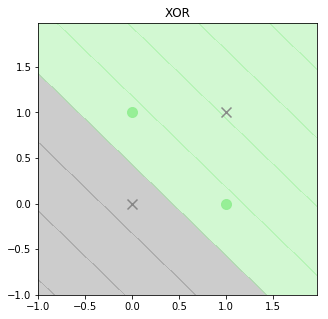

In [12]:
utils.plot_decision_regions(predict, X, Y, title='XOR');

In [13]:
utils.animate_decision_regions(X, Y, [make_predict(W, b) for W, b in parameter_history], filename='resources/logistic-xor.mp4')

# Coding an XOR neural network

To code up a solution for XOR, we'll sort of stitch together a neural network by feeding an AND and OR logistic regression solution into another logistic regression.

We can define XOR by using AND and OR as `a XOR b = (a OR b) AND NOT(a AND b)`.

|x|y|x & y|!(x & y)|x &#124; y|(x &#124; y) & !(x & y)|
|---|---|---|---|---|---|
|0|0|0|1|0|0|
|0|1|0|1|1|1|
|1|0|0|1|1|1|
|1|1|1|0|1|0|

Above, we learned a logistic regression solution for AND. We can implement `NOT(x)` as `1-x` and `OR(x, y)` by tuning the $x_0$ or $b$ term of our AND solution. Here are our AND and OR networks:

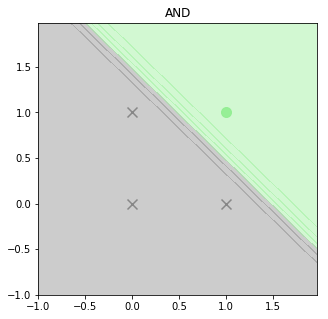

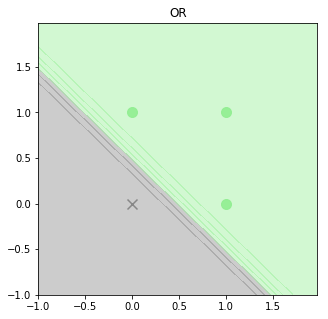

In [14]:
X = torch.tensor([[0, 0], [0, 1], [1, 0], [1, 1]]).float().T
Y = torch.tensor([0, 1, 1, 0]).float()

AND_Y = torch.tensor([0, 0, 0, 1]).float()
AND_w = torch.tensor([10, 10]).float()
AND_b = torch.tensor([-15]).float()

OR_Y = torch.tensor([0, 1, 1, 1]).float()
OR_w = AND_w.clone()
OR_b = torch.tensor([-5]).float()

def predict(X, w, b):
    return (w@X + b[:, None]).sigmoid()

utils.plot_decision_regions(lambda X: predict(X, AND_w, AND_b), X, AND_Y, title='AND')
utils.plot_decision_regions(lambda X: predict(X, OR_w, OR_b), X, OR_Y, title='OR');

The decision boundary view is helpful, but we'll try to visualize the inputs as logistic functions now. The weights for all inputs are the same, so we can do some rewriting here:

\begin{align}
\hat{y} &= \sigma\left(\sum_i w_i x_i + b\right) \\
&= \sigma\left(w \sum_i x_i + b\right) \\
&= \sigma \left( w \left( \sum_i x_i - (-b/w) \right) \right)
\end{align}

If we let $k=w$ and $x_0 = -\frac{b}{w}$, then
$$
\hat{y} = \sigma\left(k \left( \sum_i x_i - x_0 \right) \right)
$$

So, we sum across our inputs (`00` maps to `0`, `01` and `10` map to `1`, and `11` maps to `2`) and put that into the logistic regression function. Our $x_0$ determines the decision boundary. In the AND case, we set the decision boundary to $-\frac{b}{w}=\frac{15}{10}=1.5$, mapping only `11` to `1` and others to `0`. In the OR case, we set the boundary to $-\frac{b}{w}=\frac{5}{10}=0.5$, mapping only `00` to `0` and others to `1`.

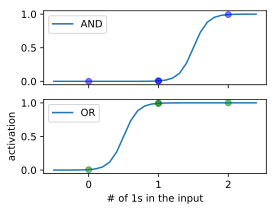

In [15]:
xs = torch.arange(-0.5, 2.5, 0.1)

f, axes = plt.subplots(2, 1, figsize=(4, 3), sharex=True)

plt.sca(axes[0])
plt.plot(xs, (AND_w[0]*xs+AND_b).sigmoid(), label='AND')
Yhat = predict(X, AND_w, AND_b).squeeze()
c='b'
for i in range(4):
    plt.plot(X[:,i].sum(), Yhat[i], c+'o', alpha=0.5)
plt.legend()

plt.sca(axes[1])
plt.plot(xs, (OR_w[0]*xs+OR_b).sigmoid(), label='OR')
Yhat = predict(X, OR_w, OR_b).squeeze()
c='g'
for i in range(4):
    plt.plot(X[:,i].sum(), Yhat[i], c+'o', alpha=0.5)
plt.legend(loc='upper left')
plt.xlabel('# of 1s in the input')
plt.ylabel('activation')
plt.xticks([0, 1, 2]);

We'll now combine those AND and OR networks to make our XOR network. We'll use the weights and bias from our AND solution above.

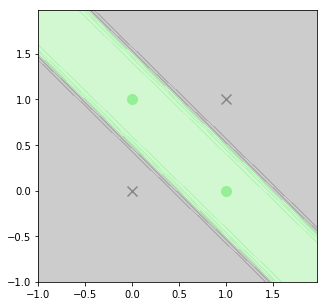

In [16]:
def XOR_predict(X):
    h = torch.cat([
        predict(X, OR_w, OR_b),
        1-predict(X, AND_w, AND_b),
    ])
    return predict(h, AND_w, AND_b)

ax = utils.plot_decision_regions(XOR_predict, X, Y)
ax.set(title='XOR');

# Learning an XOR neural network

Now, we want to learn a neural network that can compute XOR. We'll start by computing some derivatives. We want to compute the derivative of the loss w.r.t. every parameter. We'll only work through the derivations of a few.

The network projects 2D input ($x^1$ and $x^2$) to a 2D hidden layer ($h^1$ and $h^2$) to a 1D output layer. In these equations, the subscript indicates the layer number and superscript indicates the index into the vector or matrix. So, $W_1^{j,i}$ is the weight from the input $x^i$ to the hidden unit $h^j$. For vectors like $b_1$, $b_1^j$ is the bias term for the hidden unit $h^j$. Here's a schematic of the network:

<img src="resources/net-xor.svg" style="width: 400px;" />

And now the equations:

\begin{align}
z_1 &= W_1 x+b_1 = \left[ \sum_i W_1^{j,i} x^i + b_1 \right]_j \\
h &= \sigma(z_1) \\
z_2 &= W_2 h+b_2 = \left[ \sum_j W_2^{k,j} h^j + b_2 \right]_k \\
\hat{y} &= \sigma(z_2) \\
&= \sigma(W_2 \sigma(W_1 x+b_1)+b_2)
\end{align}

Let's start with $\frac{d}{dW_2^{k,j}} \hat{y}$. This will be a bit simpler since it's closer to the output, requiring fewer steps of backpropagation.
\begin{align}
\frac{d}{dW_2^{k,j}}\hat{y} &= \frac{d}{dW_2^{k,j}}\sigma(z_2) \\
&= \frac{d}{dz_2}\sigma(z_2) \frac{d}{dW_2^{k,j}}(W_2 h+b_2) \\
&= (1 - \sigma(z_2)) \sigma(z_2) h^j \\
\end{align}

Now $W_1^{j,i}$, which requires more applications of the chain rule
\begin{align}
\frac{d}{dW_1^{j,i}}\hat{y} &= \frac{d}{dW_1^{j,i}}\sigma(z_2) \\
&= \frac{d}{dz_2}\sigma(z_2) \frac{d}{dW_1^{j,i}}(W_2 h+b_2) \\
&= \frac{d}{dz_2}\sigma(z_2) \frac{d}{dW_1^{j,i}}(\sum_{j'} W_2^{1,j'} h^{j'} + b_2) \\
&= \frac{d}{dz_2}\sigma(z_2) \frac{d}{dh^j}(W_2^{1,j} h^{j} + b_2) \frac{d}{dW_1^{j,i}} \sigma(z_1^j) \\
&= \frac{d}{dz_2}\sigma(z_2) \frac{d}{dh^j}(W_2^{1,j} h^{j} + b_2) \frac{d}{dz_1^j} \sigma(z_1^j) \frac{d}{dW_1^{j,i}} (\sum_i W_1^{j,i} x^i + b_1) \\
\\
&= (1 - \sigma(z_2)) \sigma(z_2) W_2^{1,j} (1 - \sigma(z_1^j)) \sigma(z_1^j) x^i \\
\end{align}

We can plug those derivatives into our loss function:
\begin{align}
\frac{d}{dW_2^{k,j}} J(W_1, b_1, W_2, b_2) &= \frac{1}{m} \sum_{i=1}^m 2 (\hat{y}_i-y_i) (1 - \sigma(z_2)) \sigma(z_2) h^j \\
\frac{d}{dW_1^{j,i}} J(W_1, b_1, W_2, b_2) &= \frac{1}{m} \sum_{i=1}^m 2 (\hat{y}_i-y_i) (1 - \sigma(z_2)) \sigma(z_2) W_2^{1,j} (1 - \sigma(z_1^j)) \sigma(z_1^j) x^i \\
\end{align}

As above, we'll compare these derivatives to the ones PyTorch can compute automatically.

In [17]:
torch.manual_seed(42)
w1 = torch.randn(size=(2,2), requires_grad=True)
b1 = torch.randn(size=(2,1), requires_grad=True)
w2 = torch.randn(size=(1,2), requires_grad=True)
b2 = torch.randn(size=(1,1), requires_grad=True)

z1 = w1 @ X + b1
h = z1.sigmoid()
z2 = w2 @ h + b2
Yhat = z2.sigmoid()
J = ((Y-Yhat)**2).mean()

dJ_dw2 = (2 * (Yhat - Y) * logistic_derivative(z2) * h).mean(axis=1)

dJ_dw1 = torch.zeros((2, 2))
for i in range(2):
    for j in range(2):
        dJ_dw1[j, i] = (
            2 * (Yhat - Y) * logistic_derivative(z2) * w2[:, j] *
            logistic_derivative(z1[j]) * X[i]
        ).mean()

J.backward()

print('dJ/dW2', dJ_dw2.detach(), 'Automatic:', w2.grad)
print('dJ/dW2', dJ_dw1.detach())
print('Automatic:', w1.grad)

dJ/dW2 tensor([0.0235, 0.0407]) Automatic: tensor([[0.0235, 0.0407]])
dJ/dW2 tensor([[ 0.0212,  0.0210],
        [-0.0064, -0.0058]])
Automatic: tensor([[ 0.0212,  0.0210],
        [-0.0064, -0.0058]])


Now we'll use PyTorch to fit our model.

Accuracy 100.0%


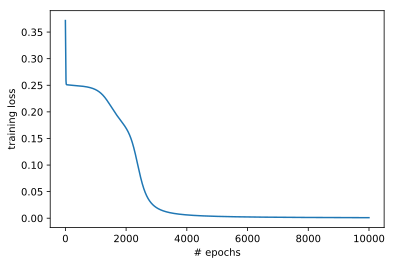

In [18]:
X = torch.tensor([[0, 0], [0, 1], [1, 0], [1, 1]]).float().T
Y = torch.tensor([0, 1, 1, 0]).float()

torch.manual_seed(42)
w1 = torch.rand((2, 2), requires_grad=True)
b1 = torch.rand((2, 1), requires_grad=True)
w2 = torch.rand((2,), requires_grad=True)
b2 = torch.rand((1,), requires_grad=True)

def predict(X):
    h = (w1 @ X + b1).sigmoid()
    return (w2 @ h + b2).sigmoid()

def loss():
    return ((Y-predict(X))**2).mean()

times, history, parameter_history = utils.fit(
    loss, [w1, b1, w2, b2], lr=0.4, num_epochs=10000)
show_accuracy(predict(X), Y)

Now we'll look at the weights as they change. We can see the weights converge for weights to the same hidden unit. We can also see the network learns similar values of $x_0$ as we used above!

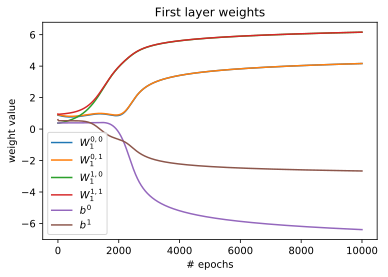

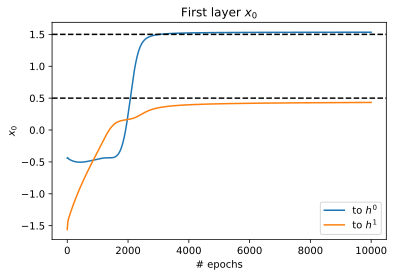

In [19]:
plt.subplots()
for i in [(0, 0), (0, 1), (1, 0), (1, 1)]:
    plt.plot([p[0][i] for p in parameter_history], label='$W_1^{'+str(i[0])+','+str(i[1])+'}$')
for i in [0, 1]:
    plt.plot([p[1][i] for p in parameter_history], label=f'$b^{i}$')
plt.title('First layer weights')
plt.xlabel('# epochs')
plt.ylabel('weight value')
plt.legend();

# Now we'll plot x_0
x0 = torch.zeros((len(parameter_history), 2))
for t in range(len(parameter_history)):
    p = parameter_history[t]
    for i in range(2):
        arbitrary = 0 # can be 0 or 1 since weights converge!
        x0[t, i] = -p[1][i] / p[0][i, arbitrary]
plt.subplots()
plt.title('First layer $x_0$')
plt.plot(x0[:, 0], label='to $h^0$')
plt.plot(x0[:, 1], label='to $h^1$')
plt.legend()
plt.ylabel('$x_0$')
plt.xlabel('# epochs')
plt.axhline(0.5, c='k', ls='--')
plt.axhline(1.5, c='k', ls='--');

Finally, we can confirm (as suggested by the prior plot) that $h^0$ implements AND and $h^1$ implements AND.

In [20]:
h = (w1@X + b1).sigmoid()
print('h^0 accuracy on AND')
show_accuracy(h[0], AND_Y)
print()

print('h^1 accuracy on OR')
show_accuracy(h[1], OR_Y)

h^0 accuracy on AND
Accuracy 100.0%

h^1 accuracy on OR
Accuracy 100.0%


Here are some videos of the learning process. The first shows points in input space, with the decision boundary drawn. The second shows points in the space defined by the hidden layer.

In [21]:
def make_predict(w1, b1, w2, b2):
    def predict(X):
        h = (w1 @ X + b1).sigmoid()
        return (w2 @ h + b2).sigmoid()
    return predict
utils.animate_decision_regions(X, Y, [make_predict(*p) for p in parameter_history[::100]], filename='resources/net-2layer-learning.mp4')

In [22]:
def make_predict_hidden(w1, b1, w2, b2):
    def predict_hidden(X):
        return (w2 @ X + b2).sigmoid()
    return predict_hidden

utils.animate_decision_regions(
    None,
    Y,
    [make_predict_hidden(*p) for p in parameter_history[::100]],
    Xhistory=[(w1 @ X + b1).sigmoid() for (w1, b1, w2, b2) in parameter_history[::100]],
    filename='resources/net-2layer-hidden-learning.mp4',
)

# Rumelhart's Semantic Network

We'll now study a neural network that can learn a semantic network! By "semantic network", we mean something like what's depicted below (from [Rumelhart and Todd 1993](https://web.stanford.edu/class/psych209a/ReadingsByDate/02_08/RumelhartTodd93.pdf)): A canary can sing. Because it's a bird, it can fly. Since it's alive, it grows. We're going to see if we can learn this kind of hierarchical structure given a dataset that consists only of the properties different animals have.

<img src="resources/rumelhart_semantics.png" style="width: 550px;" />



The network architecture we'll use is depicted below (from [McClelland and Rogers 2003](https://stanford.edu/~jlmcc/papers/McCRogers03.pdf)). Our eight different living things are mapped into a representational layer. The representational layer and units that correspond to different relations ("is", "can", "has", "is-a") map into a hidden layer. Finally, this hidden layer is mapped to outputs that correspond to different properties related to a living thing.

<img src="resources/rumelhart_net.png" style="width: 450px;" />


We import the semantics, which encodes the above tree. Make sure to actually glance at the [semantics file](rumelhart_semantics.py)! One change is we make sure that pine trees don't have leaves, which is important for a figure we want to show later.

In [23]:
import rumelhart_semantics

nouns = ['oak', 'pine', 'rose', 'daisy', 'canary', 'robin', 'salmon', 'sunfish']
relations = ['isa', 'is', 'can', 'has']
semantics = [getattr(rumelhart_semantics, n) for n in nouns]

def onehot(ordered_values, query):
    x = torch.zeros(len(ordered_values))
    for item in query:
        x[ordered_values.index(item)] = 1
    return x

xlabels = nouns + relations
onehot(xlabels, ('oak', 'is'))

tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.])

Now we'll prepare to onehot code the properties by enumerating all possible properties.

In [24]:
values = {'isa': set(), 'is': set(), 'has': set(), 'can': set()}
for n in semantics:
    for prop in n:
        values[prop[0]].add(prop[1])

ylabels = sum(map(lambda rel: sorted(list(values[rel])), relations), [])
onehot(ylabels, ('living thing', 'grow'))

tensor([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

Now we onehot code the inputs in `X` and outputs in `Y`. The inputs are a noun (oak, robin, rose, etc) and a relation (can, has, is-a, is). The outputs are any of the properties (for any relation or noun).

In [25]:
X = torch.zeros((len(nouns)*len(relations), len(xlabels)))
Y = torch.zeros((len(nouns)*len(relations), len(ylabels)))
i = 0
for noun, properties in zip(nouns, semantics):
    for relation in relations:
        X[i] = onehot(xlabels, (noun, relation))
        Y[i] = onehot(ylabels, [p[1] for p in properties if p[0] == relation])
        i += 1

We define our network. We're using a somewhat arbitrary numbers of hidden units.

In [26]:
import torch.nn as nn
import torch.nn.functional as F

class Rumelhart(nn.Module):
    def __init__(self, nouns, *,
                representation_units=9,
                relational_units=16):
        super(Rumelhart, self).__init__()
        self.nouns = nouns
        self.noun_representation = nn.Linear(len(nouns), representation_units)
        self.relational = nn.Linear(representation_units+len(relations), relational_units)
        self.output = nn.Linear(relational_units, len(ylabels))

    def forward(self, x):
        noun = x[:, :len(self.nouns)]
        relation = x[:, len(self.nouns):]
        x = self.noun_representation(noun).sigmoid()
        x = self.relational(torch.cat([x, relation], axis=1)).sigmoid()
        x = self.output(x).sigmoid()
        return x

Accuracy 100.0%


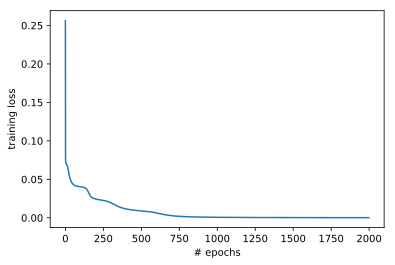

In [27]:
torch.manual_seed(42)
model = Rumelhart(nouns)

def loss():
    return ((model(X) - Y) ** 2).mean()

time, history, parameter_history = utils.fit(loss, model.parameters(), lr=150., num_epochs=2000)
show_accuracy(model(X), Y)

## A survey of results

Now we'll go through some results highlighted in Figure 4 of McClelland and Rogers 2003.

### Figure 4a: Hidden unit patterns

Here, we visualize representational units at different stages of training. Early on, the units have little discernable pattern. As training progresses, the units seem to encode detailed information more specifically. It's possible to point at weights that are likely encoding Animal vs Plant or Bird vs Fish.

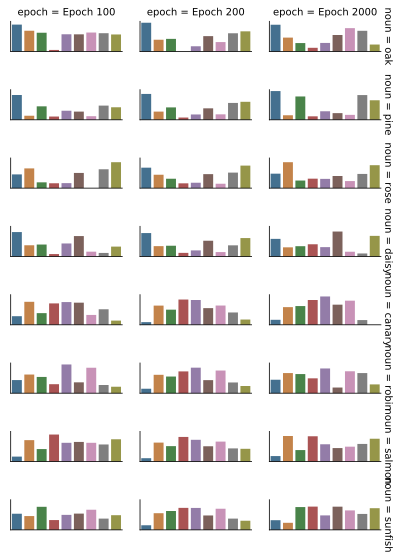

In [28]:
import pandas as pd
import seaborn as sns

rows = []
for epoch in [99, 199, 1999]:
    for nidx in range(len(nouns)):
        for widx in range(model.noun_representation.weight.shape[0]):
            w = parameter_history[epoch][0]
            # Subtracting min so all bars are positive
            w = w - w.min()
            # Normalize by max
            w = w / w.max()
            rows.append((f'Epoch {epoch+1}', nouns[nidx], widx, w[widx, nidx].item()))
df = pd.DataFrame(rows, columns=['epoch', 'noun', 'weight', 'value'])
g = sns.catplot(
    x='weight', y='value', col='epoch', row='noun',
    margin_titles=True,
    height=1,
    data=df, saturation=.5,
    kind="bar", ci=None, aspect=2)
(
    g.set(xticks=[], yticks=[])
    .set_axis_labels('', '')
)
None

### Figure 4b: Clustering over hidden units

We can perform a clustering over the hidden unit weights above to visualize the noun representations in a hierarchy. We'll use an agglomerative clustering algorithm to do so, then visualize as a dendrogram.

The agglomerative clustering algorithm used below finds the pair of weights with the smallest euclidean distance and joins them into a cluster with a weight that's the average of the pair. This process repeats until there's only one cluster. This structure can then be rendered as a dendrogram, the tree-like structure visualized below.

Some caveats: Overtraining or having too many representation units causes dendrogram to lose structure.

Accuracy 98.3%


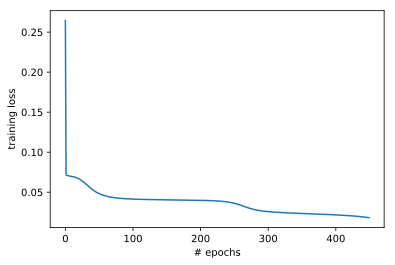

In [29]:
torch.manual_seed(44)
dendrogram_model = Rumelhart(nouns, representation_units=6)

def loss():
    return ((dendrogram_model(X) - Y) ** 2).mean()

_ = utils.fit(loss, dendrogram_model.parameters(), lr=100., num_epochs=450)
show_accuracy(dendrogram_model(X), Y)
dendrogram_w = dendrogram_model.noun_representation.weight.detach().clone()

Text(0, 0.5, 'euclidean distance')

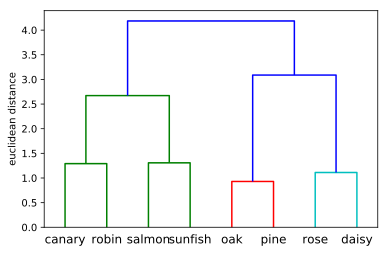

In [30]:
import scipy.cluster.hierarchy as hierarchy

Z = hierarchy.linkage(dendrogram_w.T, 'single')
f, ax = plt.subplots()
dn = hierarchy.dendrogram(Z, labels=nouns)
plt.ylabel('euclidean distance')

### Figure 4c: When does the network learn general vs specific distinctions?

Here we examine the euclidean distance between different distinctions we can make. To contrast plants and animals, we compute the average weight to the first layer for each, then plot the norm of the difference of these average weights. We clearly see that more general distinctions appear earlier, while more specific distinctions happen later.

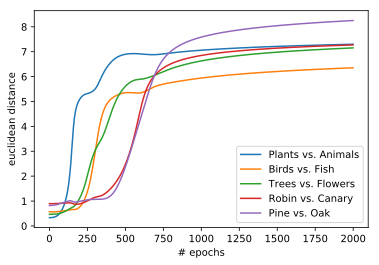

In [31]:
contrasts = [
    ('Plants vs. Animals', torch.tensor([1/4, 1/4, 1/4, 1/4, -1/4, -1/4, -1/4, -1/4])),
    ('Birds vs. Fish', torch.tensor([0, 0, 0, 0, 1/2, 1/2, -1/2, -1/2])),
    ('Trees vs. Flowers', torch.tensor([1/2, 1/2, -1/2, -1/2, 0, 0, 0, 0])),
    ('Robin vs. Canary', torch.tensor([0, 0, 0, 0, -1., 1, 0, 0])),
    ('Pine vs. Oak', torch.tensor([-1., 1, 0, 0, 0, 0, 0, 0])),
]
for title, contrast in contrasts:
    v = [(p[0] @ contrast).norm() for p in parameter_history]
    plt.plot(v, label=title)
plt.xlabel('# epochs')
plt.ylabel('euclidean distance')
plt.legend();

### Figure 4d: Learning properties

Now, we examine the timecourse for the learning of different properties. We examine the properties of the canary. Each property shown below is due to a different category it's a member of we find that properties shared by more general categories (like living thing) are learned earlier than those that are more specific (that canaries sing).

We also look at the process for learning that pine trees do not have leaves. Early on during training, the network tries to broadly apply attributes that most plants have to pine trees, but eventually learns that pine trees are an exception to those norms.

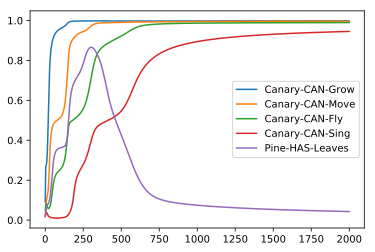

In [32]:
canary_grow = []
canary_move = []
canary_fly = []
canary_sing = []
pine_leaves = []
for params in parameter_history:
    m = Rumelhart(nouns)
    for source, dest in zip(params, m.parameters()):
        dest.data[:] = source.data[:]

    y_ = m(onehot(xlabels, ('canary', 'can'))[None, :]).flatten()
    canary_grow.append(y_[ylabels.index('grow')])
    canary_move.append(y_[ylabels.index('move')])
    canary_fly.append(y_[ylabels.index('fly')])
    canary_sing.append(y_[ylabels.index('sing')])
    y_ = m(onehot(xlabels, ('pine', 'has'))[None, :]).flatten()
    pine_leaves.append(y_[ylabels.index('leaves')])

plt.plot(canary_grow, label='Canary-CAN-Grow')
plt.plot(canary_move, label='Canary-CAN-Move')
plt.plot(canary_fly, label='Canary-CAN-Fly')
plt.plot(canary_sing, label='Canary-CAN-Sing')
plt.plot(pine_leaves, label='Pine-HAS-Leaves')
plt.legend();

### Adding something new...

We'll close with a fun experiment from Rumelhart and Todd 1993. They added "sparrow" to the network, trained it so the network new it was a bird, then explored the other properties the network inferred for it. We repeat this below. What do you think the network will do?

In [33]:
class RumelhartNewNouns(nn.Module):
    def __init__(self, model, nouns):
        super(RumelhartNewNouns, self).__init__()
        representation_units = model.noun_representation.weight.shape[0]
        relational_units = model.relational.weight.shape[0]

        self.nouns = nouns

        self.noun_representation = nn.Linear(len(nouns), representation_units)
        self.relational = nn.Linear(representation_units+len(relations), relational_units)
        self.output = nn.Linear(relational_units, len(ylabels))

        with torch.no_grad():
            # Copy over weights for nouns that already existed
            old_nouns = model.noun_representation.weight.shape[1]
            self.noun_representation.weight[:, :old_nouns] = model.noun_representation.weight[:]

            # Copy over all other weights (except the weights for noun_representation, which we skip)
            for newp, oldp in list(zip(self.parameters(), model.parameters()))[1:]:
                newp.data[:] = oldp.data[:]

    def forward(self, x):
        noun = x[:, :len(self.nouns)]
        relation = x[:, len(self.nouns):]
        x = self.noun_representation(noun).sigmoid()
        x = self.relational(torch.cat([x, relation], axis=1)).sigmoid()
        x = self.output(x).sigmoid()
        return x

In [34]:
new_nouns = nouns+['sparrow']

torch.manual_seed(42)
model_sparrow = RumelhartNewNouns(model, new_nouns)

def loss():
    x = onehot(new_nouns+relations, ('sparrow', 'isa'))[None, :]
    yhat = model_sparrow(x).squeeze()
    return (yhat[ylabels.index('bird')] - 1)**2

times, history, parameter_history = utils.fit(loss, model_sparrow.parameters(), num_epochs=2, lr=5., plot_loss=False)

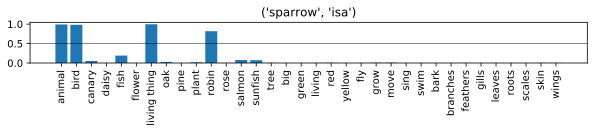

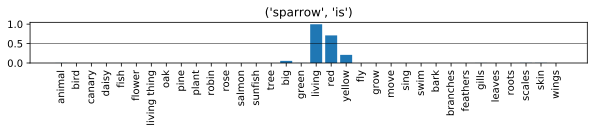

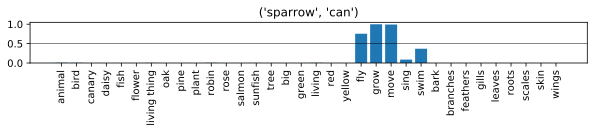

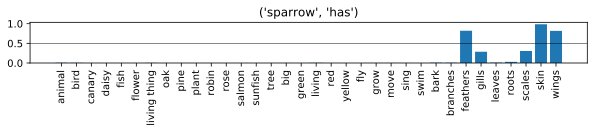

In [35]:
def plot_predictions(model, query):
    x = onehot(model.nouns+relations, query)[None, :]
    yhat = model(x).squeeze()
    plt.subplots(figsize=(10, 0.75))
    plt.title(str(query))
    plt.bar(range(len(yhat)), yhat.detach())
    plt.xticks(range(len(yhat)), labels=ylabels, rotation=90)
    plt.yticks([0, 0.5, 1])
    plt.axhline(0.5, lw=0.5, c='k')

for relation in relations:
    plot_predictions(model_sparrow, ('sparrow', relation))